<a href="https://colab.research.google.com/github/yishengli/GraphMiningNotebooks/blob/master/Gomez_Li_Assignment4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install python-igraph

     |████████████████████████████████| 3.2 MB 5.4 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9070 sha256=4814210cf4090fc142bc380cb0706eeec22ddd98520b2b6d1187f54f27988ccd
  Stored in directory: /root/.cache/pip/wheels/15/86/ef/b8bcdfbcb1c489771ad256c7cd1eb4971cdb7f3f670938b798
Successfully built python-igraph


In [2]:
pip install plfit

     |████████████████████████████████| 193 kB 5.2 MB/s 
  Created wheel for plfit: filename=plfit-1.0.3-cp37-cp37m-linux_x86_64.whl size=123187 sha256=c3dd7113de406b54b0c0ec8505601284e77d94a29cad7353f7e3685c9fb5e94e
  Stored in directory: /root/.cache/pip/wheels/44/c5/30/2761386f6aea1d7ca4ffb706f90535faa81365be034b32055a
Successfully built plfit


In [3]:
datadir = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/'

In [4]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import plfit
import random
import math

In [5]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [6]:
## Degree correlation functions
## as defined in section 4.5:
## k_nn^{mode1,mode2}(l) : average mode2-degree of mode1-neighbours of nodes with mode1-degree = l
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v, mode='out')]
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L)) if len(L[i])>0}

# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        # w = [deg[i] for i in list(set(G.neighbors(v)))] 
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graphs: <k^2>/<k>
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

## for a fixed l -- can be slow for multiple l's
def richClub(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat

def plot_corr(gh, title):
    knn_gh = deg_corr(gh)
    x_gh = list(knn_gh.keys())
    y_gh = list(knn_gh.values())
    r_gh = deg_corr_neutral(gh)
    plt.scatter(x_gh,y_gh,c='black')
    plt.hlines(y=r_gh,xmin=min(x_gh),xmax=max(x_gh),linestyles=':')
    plt.title(f'Degree correlation function - Github {title} Graph')
    plt.xlabel(r'degree ($\ell$)',fontsize=12)
    plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
    
def plot_rich_club(g, title):
    d = list(set(g.degree()))
    rc = [richClub(g, l=i) for i in d]
    # for i in d:
    #     rc.append(richClub(g, l=i))
    plt.title(f'{title} Graph')
    plt.semilogx(d, rc,'.',c='black')
    plt.xlabel(r'degree $\ell$',fontsize=12)
    plt.ylabel(r'rich club coefficient $\rho(\ell)$');

# Problem 1

In [7]:
musae_git_target_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GitHubDevelopers/musae_git_target.csv'
musae_git_edges_url = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/GitHubDevelopers/musae_git_edges.csv'

In [8]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(musae_git_edges_url)
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## add some node features, here there are two class of nodes
## 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(musae_git_target_url)
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
#gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey' ## edge color

## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


In [9]:
## Simplify graphs
gh = gh.subgraph([v for v in gh.vs() if v.degree()>0])
gh_ml = gh_ml.subgraph([v for v in gh_ml.vs() if v.degree()>0])
gh_web = gh_web.subgraph([v for v in gh_web.vs() if v.degree()>0])
gh = gh.simplify(multiple=False)
gh_ml = gh_ml.simplify(multiple=False)
gh_web = gh_web.simplify(multiple=False)

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 7431 ; web developers: 27676


a. Degree correlation function and uncorrelated counterpart

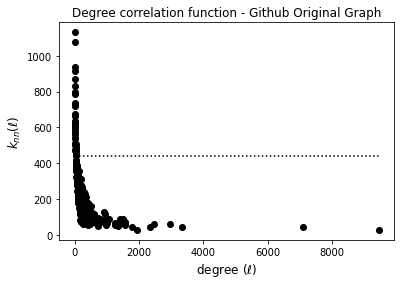

In [ ]:
plot_corr(gh, 'Original')

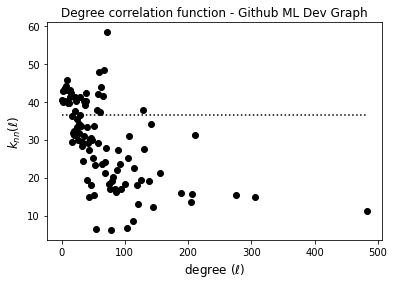

In [ ]:
plot_corr(gh_ml, 'ML Dev')

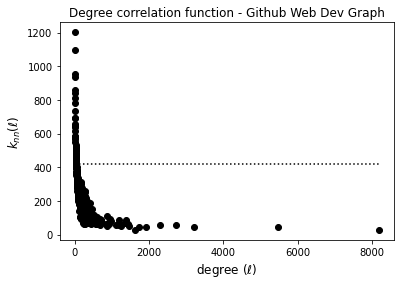

In [ ]:
plot_corr(gh_web, 'Web Dev')

b. Degree correlation coefficient r

In [ ]:
## Original Github graph
r_gh = gh.assortativity_degree()
print('Assortativity degree - Github Original Graph: ', r_gh)

## Machine Learning Dev Graph
r_ml = gh_ml.assortativity_degree()
print('Assortativity degree - ML Dev Graph: ', r_ml)

## Web Dev Graph
r_web = gh_web.assortativity_degree()
print('Assortativity degree - Web Dev Graph: ', r_web)

Assortativity degree - Github Original Graph:  -0.07521713413904482
Assortativity degree - ML Dev Graph:  -0.09098692775064464
Assortativity degree - Web Dev Graph:  -0.08714757315866846


c. Correlation exponent u

In [ ]:
## Original Github graph
mu_gh = corr_exp(gh)
print('Correlation exponent for Github Original Graph: ', mu_gh)

## Machine Learning Dev Graph
mu_ml = corr_exp(gh_ml)
print('Correlation exponent for ML Dev Graph: ', mu_ml)

## Web Dev Graph
mu_web = corr_exp(gh_web)
print('Correlation exponent for Web Dev Graph: ', mu_web)

Correlation exponent for Github Original Graph:  -0.5076879013701244
Correlation exponent for ML Dev Graph:  -0.2514234876818035
Correlation exponent for Web Dev Graph:  -0.5151040696086916


d. Rich-club coefficient

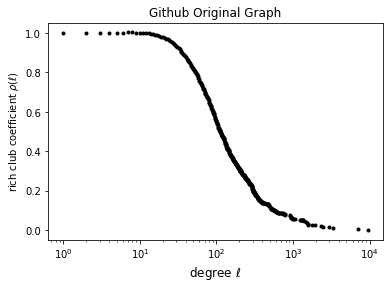

In [ ]:
plot_rich_club(gh, 'Github Original')

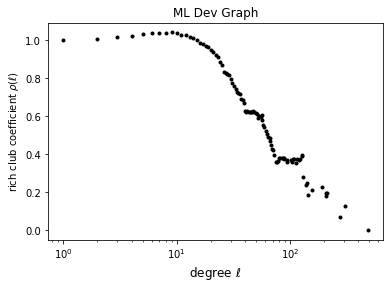

In [ ]:
plot_rich_club(gh_ml, 'ML Dev')

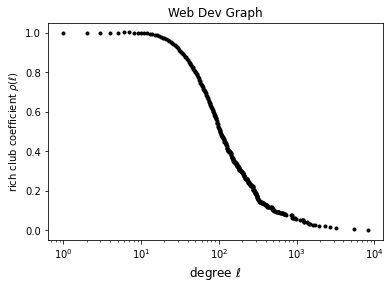

In [ ]:
plot_rich_club(gh_web, 'Web Dev')

# Problem 2

In [50]:
def switching_full_new(e1, n):
    """
    Our customized rewire/switching function.
    e1 --- the edgelist to be rewired 
    n --- the length of e1
    This function returns a new edgelist e2 and all the edges that have been rewired (i.e., switched).
    """
    e1 = set(e1)
    e2 = e1
    counter = 0
    switched = set()
    while len(switched) < n:
        to_switch = random.sample(e2, 2)
        test = set([(to_switch[0][0], to_switch[1][0]), (to_switch[0][1], to_switch[1][1])])
        counter += 1
        if all(i not in e2 for i in test):
            e2 = e2-set(to_switch)
            e2.update([(to_switch[0][0], to_switch[1][1])])
            switched.update([i for i in to_switch if i not in switched and i in e1])
    print(len(switched))
    print(counter)
    
    return list(e2), list(switched)
    
def switching_by_trial(e1, t):
    """
    Our customized rewire/switching function.
    e1 --- the edgelist to be rewired
    t --- the length of trials
    This function returns a new edgelist e2 and all the edges that have been rewired (i.e., switched).
    """
    e2 = e1
    counter = 0
    switched = set()
    while counter <= t:
        to_switch = random.sample(e2, 2)
        test = set([(to_switch[0][0], to_switch[1][0]), (to_switch[0][1], to_switch[1][1])])
        counter += 1
        if all(i not in e2 for i in test):
            e2 = set(e2)-set(to_switch)
            e2.update([(to_switch[0][0], to_switch[1][1])])
            switched.update([i for i in to_switch if i not in switched and i in e1])
    print('number of switched edges = ', len(switched))
    print('number of trials = ', counter)
    
    return list(e2), list(switched)

def intersection(lst1, lst2, c=1):
 
    # Use of hybrid method
    lst3 = [value for value in lst1 if value in set(lst2)]
    print('c = ', c)
    print('empirical number of unswitched edges = ', len(lst3))
    print('theoretical number of unswitched edges = ', math.exp(-2*c)*(len(lst2)))

    return lst3

def rewire_graph(gh, not_switched, switched):
    gh_rewired = gh.copy()
    gh_rewired.delete_edges()
    gh_rewired.add_edges(not_switched)
    gh_rewired.add_edges(switched)

    return gh_rewired
    
def random_plot(gh, gh_rewired, c=1):
    rand_knn = deg_corr(gh_rewired)
    xr = list(rand_knn.keys())
    yr = list(rand_knn.values())
    ## Degree correlation
    knn = deg_corr(gh)
    x = list(knn.keys())
    y = list(knn.values())
    ## Uncorrelated neutral value
    r = deg_corr_neutral(gh)
    plt.scatter(x, y, c='black')
    plt.scatter(xr, yr, c='grey')
    plt.hlines(y=r, xmin=min(x), xmax=max(x), linestyles=':')
    plt.title(f'Randomized (c = {c}) vs. Regular Degree correlation function')
    plt.xlabel(r'degree ($\ell$)',fontsize=12)
    plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);

In [46]:
g = gh.copy()
# g = gh_ml.copy()
e1 = g.get_edgelist()
## Calling the switching/rewiring function
n = len(e1)
e2, switched = switching_full_new(e1, n)

289003
293073


In [47]:
unswitched = intersection(e1, e2)

c =  1
empirical number of unswitched edges =  22
theoretical number of unswitched edges =  78.08845842752552


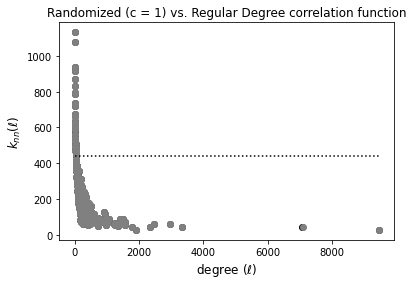

In [53]:
gh_rewired = rewire_graph(g, unswitched, switched)
random_plot(g, gh_rewired, c=1)

(Almost) completely overlap!

# Problem 3

Note: *We couldn't retrieve experimental results within a reasonable timeframe due to the size of the entire graph. Instead, we have to run a smaller subgraph (i.e., github machine learning). The empirical results are consistent with theoretical ones:)* 

In [ ]:
m = len(gh_ml.get_edgelist())
c_lst = [0.5, 1, 2]
e_before = gh_ml.get_edgelist()
t_lst = [int(i*m) for i in c_lst]

e_after1, switched1 = switching_by_trial(e_before, t_lst[0])
e_after2, switched2 = switching_by_trial(e_before, t_lst[1])
e_after3, switched3 = switching_by_trial(e_before, t_lst[2])

number of switched edges =  19282
number of trials =  39369


In [ ]:
not_switched1 = intersection(e_before, e_after1, c_lst[0])

c =  0.5
empirical number of unswitched edges =  7458
theoretical number of unswitched edges =  7241.338920018671


In [ ]:
not_switched2 = intersection(e_before, e_after2, c_lst[1])

c =  1
empirical number of unswitched edges =  2932
theoretical number of unswitched edges =  2663.9397152294846


In [ ]:
not_switched3 = intersection(e_before, e_after3, c_lst[2])

c =  2
empirical number of unswitched edges =  565
theoretical number of unswitched edges =  360.5250358858436


In [ ]:
gh_ml_rewired1 = rewire_graph(gh_ml, not_switched1, switched1)
gh_ml_rewired2 = rewire_graph(gh_ml, not_switched2, switched2)
gh_ml_rewired3 = rewire_graph(gh_ml, not_switched3, switched3)

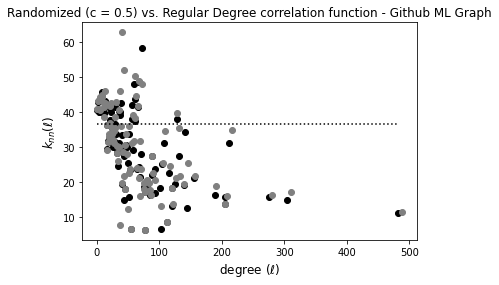

In [ ]:
random_plot(gh_ml, gh_ml_rewired1, c_lst[0])

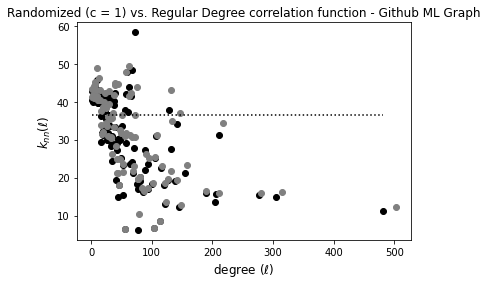

In [ ]:
random_plot(gh_ml, gh_ml_rewired2, c_lst[1])

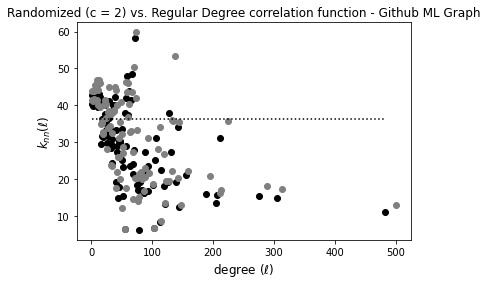

In [ ]:
random_plot(gh_ml, gh_ml_rewired3, c_lst[2])

#Problem 5

In [ ]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

def dist(gamma, n=1000, delta=100, Delta=np.sqrt(1000)):
    d = [delta * (n/(i-1+n/(Delta/delta)**(gamma1-1)))**(1/(gamma-1)) for i in np.arange(1,n+1)]
    m = int(np.mean(d)*n/2)

    return d, m
    
def weighted_CL(tpl, d):
    g = ig.Graph.TupleList(tpl, directed=True)
    g.es['weight'] = d

    return g
    
def friendship_paradox(g):
    deg = [v.degree() for v in g.vs()]
    nad = []
    for v in g.vs():
        nv = g.neighbors(v)
        nad.append(np.mean([deg[i] for i in nv]))

    plt.scatter(deg,nad,c='black',marker='.')
    plt.xlim((0,200))
    plt.ylim((0,200))
    plt.xlabel('node degree', fontsize=14)
    plt.ylabel('average neighbour degree', fontsize=14);
    plt.plot([0,200],[0,200],'--', c='gray')
    print('r =',g.assortativity_degree());
    
def plot_rich_club(g):
    d = list(set(g.degree()))
    rc = [richClub(g, l=i) for i in d]
    # for i in d:
    #     rc.append(richClub(g, l=i))
    plt.semilogx(d, rc,'.',c='black')
    plt.xlabel(r'degree $\ell$',fontsize=12)
    plt.ylabel(r'rich club coefficient $\rho(\ell)$');

In [ ]:
## power law graph
gamma1 = 2.1
gamma2 = 2.5
gamma3 = 2.9
##n = 10000
n = 1000
## min and max degrees
delta = 100
Delta = np.sqrt(n)
# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation

In [ ]:
d1, m1 = dist(gamma1)
d2, m2 = dist(gamma2)
d3, m3 = dist(gamma3)
tpl1 = fastCL(d1,m1)
tpl2 = fastCL(d2,m2)
tpl3 = fastCL(d3,m3)
g1 = weighted_CL(tpl1, d1)
g2 = weighted_CL(tpl2, d2)
g3 = weighted_CL(tpl3, d3)

r = -0.3507871724478586


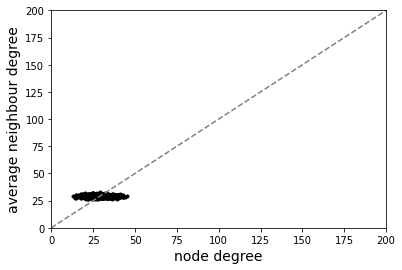

In [ ]:
friendship_paradox(g1)

r = -0.37462114785595163


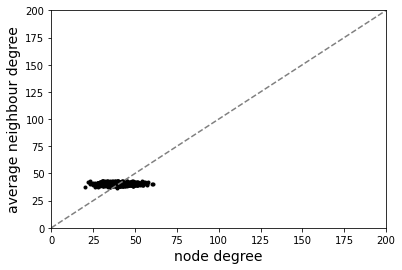

In [ ]:
friendship_paradox(g2)

r = -0.3937378531887601


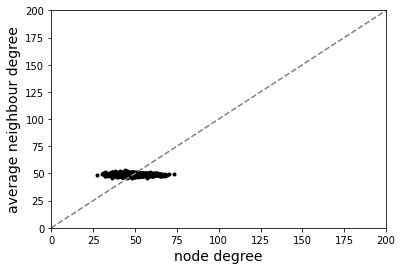

In [ ]:
friendship_paradox(g3)

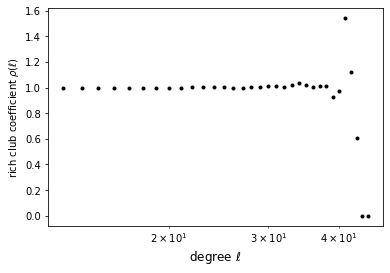

In [ ]:
plot_rich_club(g1)

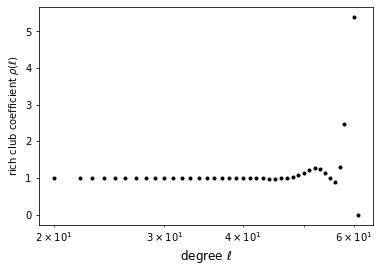

In [ ]:
plot_rich_club(g2)

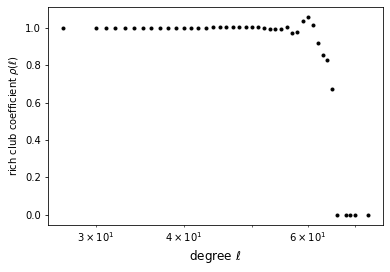

In [ ]:
plot_rich_club(g3)